In [1]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [88]:
# Read in the data
df = pd.read_csv('statements.csv')

print(df)

# Remove punctuation and convert to lowercase
df['text'] = df['text'].str.replace('[^\w\s]', '', regex=True).str.lower()

# Remove stopwords
stopwords = pd.read_csv('NLTK_English_stopwords.txt', header=None)
stopwords = stopwords[0].tolist()
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

# Remove numbers
df['text'] = df['text'].str.replace('\d+', '', regex=True)

# Remove one and two-letter words
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

# Show the number of unique words in the dataset
print('Number of unique words: ', len(set(' '.join(df['text']).split())))

# Show the top 10 most common words
print('Top 10 most common words:\n', pd.Series(' '.join(df['text']).split()).value_counts()[:10])

      id speaker                                               text
0      0   obama  During the recession, Marvin’s competitors clo...
1      1   obama  And we will rise or fall on that journey as on...
2      2   obama  My -- My differences with him -- My difference...
3      3   obama  That's why we've excluded lobbyists from polic...
4      4   obama  I recognize that many still have a strong desi...
..   ...     ...                                                ...
995  995   trump  I would like to ask now that we all observe a ...
996  996   trump  If I don’t give the answer, I’m not going to w...
997  997   trump  But after what you said about me how can you p...
998  998   trump  We wanted to get it out really, really quickly...
999  999   trump  And I will say this, this is going to be an el...

[1000 rows x 3 columns]
Number of unique words:  2724
Top 10 most common words:
 going      114
people     107
know        72
said        58
thats       48
country     47
one         

In [43]:
# For each word in the dataset, create a table reporting: the word, the number of occurrences of the word, the number of occurrences of the word in sentences spoken by Obama, the number of occurrences of the word in sentences spoken by Trump, and the phi coefficient for each word. Clearly identify the 10 words most closely correlated with Donald Trump (highest phi coefficients) as well as the 10 words most closely correlated with Barack Obama (lowest phi coefficients).

# Create a table with the number of occurrences of each word
word_counts = pd.Series(' '.join(df['text']).split()).value_counts().reset_index()
word_counts.columns = ['word', 'count']

# Create a table with the number of occurrences of each word in sentences spoken by Obama
obama_word_counts = df[df['speaker'] == 'obama']['text'].str.split(expand=True).stack().value_counts().reset_index()
obama_word_counts.columns = ['word', 'obama_count']

# Create a table with the number of occurrences of each word in sentences spoken by Trump
trump_word_counts = df[df['speaker'] == 'trump']['text'].str.split(expand=True).stack().value_counts().reset_index()
trump_word_counts.columns = ['word', 'trump_count']

# Create a table with the number of sentences containing each word spoken by Obama
obama_word_sentences = pd.DataFrame(
    [[f' {word} ' in f' {sentence} ' for word in obama_word_counts['word']] for sentence in
     df[df['speaker'] == 'obama']['text']])
obama_sentences = np.sum(obama_word_sentences, axis=0)
obama_sentence_count = pd.DataFrame({'word': obama_word_counts['word'], 'obama_sentence_count': obama_sentences})

# Create a table with the number of sentences containing each word spoken by Trump
trump_word_sentences = pd.DataFrame(
    [[f' {word} ' in f' {sentence} ' for word in trump_word_counts['word']] for sentence in
     df[df['speaker'] == 'trump']['text']])
trump_sentences = np.sum(trump_word_sentences, axis=0)
trump_sentence_count = pd.DataFrame({'word': trump_word_counts['word'], 'trump_sentence_count': trump_sentences})

# Merge the tables
word_counts = word_counts.merge(obama_word_counts, on='word', how='left')
word_counts = word_counts.merge(obama_sentence_count, on='word', how='left')
word_counts = word_counts.merge(trump_word_counts, on='word', how='left')
word_counts = word_counts.merge(trump_sentence_count, on='word', how='left')

# Replace NaN values with zeros
word_counts = word_counts.fillna(0)

# Calculate the phi coefficient for each word

# Compute the total number of sentences spoken by Obama and Trump
total_sentences_obama = df[df['speaker'] == 'obama']['text'].count()
total_sentences_trump = df[df['speaker'] == 'trump']['text'].count()

# Compute the contingency table and phi coefficient for each word
for index, row in word_counts.iterrows():
    a = row['trump_sentence_count']
    b = row['obama_sentence_count']
    c = total_sentences_trump - a
    d = total_sentences_obama - b
    phi = (a * d - b * c) / np.sqrt((a + b) * (c + d) * (a + c) * (b + d))
    word_counts.at[index, 'phi'] = phi
print(word_counts)

# Show the 10 words most closely correlated with Donald Trump (highest phi coefficients)
print('10 words most closely correlated with Donald Trump:\n', word_counts.sort_values('phi', ascending=False)[:10])

# Show the 10 words most closely correlated with Barack Obama (lowest phi coefficients)
print('10 words most closely correlated with Barack Obama:\n', word_counts.sort_values('phi', ascending=True)[:10])

word_counts

            word  count  obama_count  obama_sentence_count  trump_count  \
0          going    114         15.0                  15.0         99.0   
1         people    107         43.0                  42.0         64.0   
2           know     72         16.0                  16.0         56.0   
3           said     58         12.0                  10.0         46.0   
4          thats     48         24.0                  23.0         24.0   
...          ...    ...          ...                   ...          ...   
2719   refocused      1          1.0                   1.0          0.0   
2720     drawing      1          1.0                   1.0          0.0   
2721    shinseki      1          1.0                   1.0          0.0   
2722         ric      1          1.0                   1.0          0.0   
2723  competence      1          0.0                   0.0          1.0   

      trump_sentence_count       phi  
0                     81.0  0.224039  
1                    

,word,count,obama_count,obama_sentence_count,trump_count,trump_sentence_count,phi
0,going,114,15.0,15.0,99.0,81.0,0.224039
1,people,107,43.0,42.0,64.0,61.0,0.062508
2,know,72,16.0,16.0,56.0,54.0,0.148934
3,said,58,12.0,10.0,46.0,43.0,0.147299
4,thats,48,24.0,23.0,24.0,23.0,0.000000
...,...,...,...,...,...,...,...
2719,refocused,1,1.0,1.0,0.0,0.0,-0.031639
2720,drawing,1,1.0,1.0,0.0,0.0,-0.031639
2721,shinseki,1,1.0,1.0,0.0,0.0,-0.031639
2722,ric,1,1.0,1.0,0.0,0.0,-0.031639


In [44]:
# Define a function to calculate the log probability of a sentence given a speaker
def log_prob(sentence, speaker):
    # Calculate the log probability of the sentence given the speaker
    log_prob = np.log(prior_prob[speaker])
    for word in sentence.split():
        if word in word_prob.columns:
            log_prob += np.log(word_prob.loc[speaker, word])
    return log_prob


# Define a function to predict the speaker of a sentence
def predict_speaker(sentence):
    # Calculate the log probability of the sentence given Trump
    log_prob_trump = log_prob(sentence, 'trump')
    # Calculate the log probability of the sentence given Obama
    log_prob_obama = log_prob(sentence, 'obama')
    # Return 1 if the sentence is more likely to be spoken by Trump, 0 otherwise
    if log_prob_trump > log_prob_obama:
        return '1'
    else:
        return '0'


# Define a function to calculate the metrics of the classifier
def calculate_metrics(df):
    tp = len(df[(df['speaker'] == 'trump') & (df['prediction'] == '1')])
    tn = len(df[(df['speaker'] == 'obama') & (df['prediction'] == '0')])
    fp = len(df[(df['speaker'] == 'obama') & (df['prediction'] == '1')])
    fn = len(df[(df['speaker'] == 'trump') & (df['prediction'] == '0')])

    # Calculate the accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-10)

    # Calculate the sensitivity
    sensitivity = tp / (tp + fn + 1e-10)

    # Calculate the specificity
    specificity = tn / (tn + fp + 1e-10)

    # Calculate the precision
    precision = tp / (tp + fp + 1e-10)

    # Calculate the F1 score
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-10)

    return accuracy, sensitivity, specificity, precision, f1_score

In [45]:
# Implement a Naive Bayes classifier to predict the speaker of a sentence. Because each word is a feature and the values of P(word | class) are quite small, you will want to work with the log probabilities and compute a log score for each class to determine the predicted speaker of each sentence. We will assume that a "positive" (prediction=1) is a sentence spoken by Trump.

# Calculate the prior probability of each speaker
prior_prob = df['speaker'].value_counts() / len(df)

# Create a list of unique words in the dataset
word_list = list(set(' '.join(df['text']).split()))

# Calculate the probability of each word given each speaker
word_prob = pd.DataFrame(columns=word_list)
for speaker in ['obama', 'trump']:
    # Calculate the number of words spoken by each speaker
    num_words = len(' '.join(df[df['speaker'] == speaker]['text']).split())
    # Calculate the number of times each word was spoken by each speaker
    word_count = df[df['speaker'] == speaker]['text'].str.split(expand=True).stack().value_counts()
    # Calculate the probability of each word given each speaker
    word_prob.loc[speaker] = word_count / num_words

# Replace NaN values with zeros
word_prob = word_prob.fillna(1e-10)  # assume a small probability for missing words
print(word_prob)

            effects     objection      days          wars     existence  \
obama  2.547122e-04  5.094244e-04  0.000764  2.547122e-04  2.547122e-04   
trump  1.000000e-10  1.000000e-10  0.001064  1.000000e-10  1.000000e-10   

               sign      fairness        finish        worlds  historically  \
obama  1.000000e-10  1.000000e-10  1.000000e-10  2.547122e-04  2.547122e-04   
trump  1.330141e-03  2.660282e-04  7.980846e-04  1.000000e-10  1.000000e-10   

       ...    friend    prosperous         sleep    dollar        cutoff  \
obama  ...  0.000509  2.547122e-04  1.000000e-10  0.000255  2.547122e-04   
trump  ...  0.000532  1.000000e-10  2.660282e-04  0.000266  1.000000e-10   

           children          push         grace     locations        obtain  
obama  1.018849e-03  1.000000e-10  2.547122e-04  1.000000e-10  2.547122e-04  
trump  1.000000e-10  2.660282e-04  1.000000e-10  2.660282e-04  1.000000e-10  

[2 rows x 2724 columns]


In [46]:
# Calculate the log probability of each sentence given each speaker
df['log_prob_trump'] = df['text'].apply(lambda x: log_prob(x, 'trump'))
df['log_prob_obama'] = df['text'].apply(lambda x: log_prob(x, 'obama'))

# Calculate the predicted speaker for each sentence
df['prediction'] = df['text'].apply(lambda x: predict_speaker(x))

# Calculate the metrics of the classifier
accuracy, sensitivity, specificity, precision, f1 = calculate_metrics(df)

# Print the metrics of the classifier
print('Accuracy:', accuracy)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('Precision:', precision)
print('F1 score:', f1)

# Calculate the number of false positives
print('Number of false positives:', len(df[(df['prediction'] == '1') & (df['speaker'] == 'obama')]))

# Calculate the number of false negatives
print('Number of false negatives:', len(df[(df['prediction'] == '0') & (df['speaker'] == 'trump')]))

df

Accuracy: 0.9889999999999011
Sensitivity: 0.9939999999998013
Specificity: 0.9839999999998033
Precision: 0.9841584158413893
F1 score: 0.9890547263179637
Number of false positives: 8
Number of false negatives: 3


,id,speaker,text,log_prob_trump,log_prob_obama,prediction
0,0,obama,recession marvins competitors closed dozens pl...,-129.574065,-69.690896,0
1,1,obama,rise fall journey one nation one people,-59.846585,-46.829498,0
2,2,obama,differences differences personal,-54.283610,-24.132982,0
3,3,obama,thats weve excluded lobbyists policymaking job...,-163.992662,-74.405226,0
4,4,obama,recognize many still strong desire focus past,-98.341624,-48.072419,0
...,...,...,...,...,...,...
995,995,trump,would like ask observe moment silence victims ...,-56.486385,-119.829631,1
996,996,trump,dont give answer going win write incredibly ne...,-54.056741,-104.345187,1
997,997,trump,said possibly join team said,-33.502258,-81.351639,1
998,998,trump,wanted get really really quickly pertain whats...,-53.446310,-94.286570,1


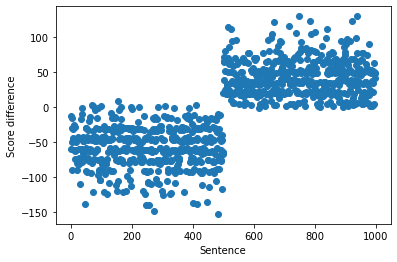

In [47]:
# For each of the sentences in the dataset, plot the score difference between the log probability of the sentence given Trump and the log probability of the sentence given Obama.

# Calculate the score difference between the log probability of the sentence given Trump and the log probability of the sentence given Obama
df['score_diff'] = df['log_prob_trump'] - df['log_prob_obama']

# Plot the score difference between the log probability of the sentence given Trump and the log probability of the sentence given Obama using a scatterplot
plt.scatter(df['id'], df['score_diff'])
plt.xlabel('Sentence')
plt.ylabel('Score difference')
plt.show()

In [81]:
def word_vector(words, word_list, use_frequency=False):
    """ Convert a list of words to a vector by comparing with words in word_list
    words: A list of words which we convert to a vector
    word_list: The chosen words against which we compare
    use_frequency: if False, vector components are 1/0, else n = # of occurrences
    """

    word_list = sorted(list(set(word_list)))

    if use_frequency:
        count = Counter(words)
        return [count[w] for w in word_list]
    else:
        return [int(w in words) for w in word_list]

# Define a function to calculate the Euclidean distance between two sentences
def euclidean_distance(sentence1, sentence2):
    # Convert the sentences to vectors
    vector1 = word_vector(sentence1, top_word_subset['word'])
    vector2 = word_vector(sentence2, top_word_subset['word'])
    # Calculate the Euclidean distance between the vectors
    distance = np.linalg.norm(np.array(vector1) - np.array(vector2))
    return distance

# Define a function to calculate k-NN
def knn(sentence, k, df_train):
    # Calculate the Euclidean distance between the sentence and each sentence in the dataset
    df_train['distance'] = df_train['text'].apply(lambda x: euclidean_distance(sentence, x))
    # Sort the dataset by distance
    df_sorted = df_train.sort_values(by='distance', ascending=True)
    # Select the top k sentences
    df_knn = df_sorted.head(k)

    # Calculate the probability of the sentence being spoken by Trump
    prob_trump = len(df_knn[df_knn['speaker'] == 'trump']) / k
    # Calculate the probability of the sentence being spoken by Obama
    prob_obama = len(df_knn[df_knn['speaker'] == 'obama']) / k

    # Return 1 if the sentence is more likely to be spoken by Trump, 0 if the sentence is more likely to be spoken by Obama
    if prob_trump > prob_obama:
        return '1'
    else:
        return '0'

# Define a function to perform n-fold cross validation on the k-NN classifier
def cross_validation(n, k):
    # Calculate the size of each fold
    fold_size = int(len(df2) / n)
    # Initialize a DataFrame to store the metrics of each fold
    df_metrics = pd.DataFrame(columns=['accuracy', 'sensitivity', 'specificity', 'precision', 'f1'])

    # Perform n-fold cross validation
    for i in range(n):
        # Select the training set
        df_train = pd.concat([df2.iloc[:i * fold_size], df2.iloc[(i + 1) * fold_size:]]).reset_index(drop=True)
        # Select the test set
        df_test = df2.iloc[i * fold_size:(i + 1) * fold_size].reset_index(drop=True)
        # Calculate the predicted speaker for each sentence in the test set
        df_test['prediction'] = df_test['text'].apply(lambda x: knn(x, k, df_train))
        # Calculate the metrics of the classifier
        accuracy, sensitivity, specificity, precision, f1 = calculate_metrics(df_test)
        # Append the metrics to the DataFrame
        df_metrics.loc[i] = [accuracy, sensitivity, specificity, precision, f1]
    # Calculate the average metrics across all folds
    df_metrics.loc['mean'] = df_metrics.mean()
    return df_metrics

In [82]:
# Select a subset of words to be used for k-NN learning.

# Select a subset of words to be used for k-NN learning. We will use the 1000 words that have the highest absolute phi coefficient.

df2 = df.copy()
df2.drop(columns=['prediction'])

# Select the 1000 words with the highest absolute value phi coefficient
word_subset = list(word_counts['phi'].abs().sort_values(ascending=False).head(1000).index)
top_word_subset = word_counts.loc[word_counts.index.isin(word_subset)].sort_values(by='count', ascending=False).reset_index(drop=True)
print(top_word_subset)

# Shuffle the dataset
df2 = df2.sample(frac=1).reset_index(drop=True)

# Vectorize the sentences in the dataset using the word subset
df2['vector'] = df2['text'].apply(lambda x: word_vector(x, top_word_subset['word']))
print(df2)

# Using k-NN, assess the performance of nearest neighbor learning using n-fold cross validation

# Run k-NN using different values of k and plot the accuracy of the classifier

# Initialize a list to store the accuracy of the classifier for each value of k
accuracy_list = []

# For odd values of k from 1 to 9
for k in range(1, 32, 2):
    # Calculate the accuracy of the k-NN classifier using 10-fold cross validation
    df_metrics = cross_validation(10, k)

    # Store the accuracy of the classifier
    accuracy_list.append(df_metrics['accuracy']['mean'])
    print(df_metrics)

           word  count  obama_count  obama_sentence_count  trump_count  \
0         going    114         15.0                  15.0         99.0   
1        people    107         43.0                  42.0         64.0   
2          know     72         16.0                  16.0         56.0   
3          said     58         12.0                  10.0         46.0   
4       country     47         18.0                  17.0         29.0   
..          ...    ...          ...                   ...          ...   
995      enrich      1          1.0                   1.0          0.0   
996     worship      1          1.0                   1.0          0.0   
997  conditions      1          1.0                   1.0          0.0   
998        lays      1          1.0                   1.0          0.0   
999         ric      1          1.0                   1.0          0.0   

     trump_sentence_count       phi  
0                    81.0  0.224039  
1                    61.0  0.062508

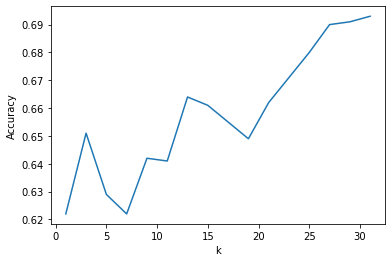

In [86]:
# Plot the accuracy of the classifier for each value of k
plt.plot(range(1, 32, 2), accuracy_list)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()